### 步骤：
* 1. 数据可视化，查看违约率，各数据分布，以及有无缺失值
* 2. 分桶，qcut, cut
* 3. 计算WOE,IV，筛选变量
* 4. 利用LR模型进行预测
* 5. 构造评分卡模型进行预测，两个假设一个类比
* 6. 对比总结

In [1]:
# Thinking
# 分桶是不是要train test一起分才可以？
# Yes,不然pcut的时候，test和train的桶就不统一了

In [2]:
import pandas as pd
import numpy as np
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('./cs-training.csv')
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
test = pd.read_csv('./cs-test.csv')

In [6]:
#test.head()

In [7]:
# 去除没用的Unnamed
train.drop(columns=train.columns[0], inplace=True)
test.drop(columns=test.columns[0], inplace=True)

#### 标签

In [8]:
# 查看SeriousDlqin2yrs，违约率
train.SeriousDlqin2yrs.value_counts().plot(kind='bar')

In [9]:
# 违约率
train.SeriousDlqin2yrs.value_counts()[1]/train.SeriousDlqin2yrs.value_counts().sum()

0.06684

In [10]:
odds = train.SeriousDlqin2yrs.value_counts()[1]/train.SeriousDlqin2yrs.value_counts()[0]
odds

0.07162758798062498

#### 缺失值

In [11]:
# MonthlyIncome, NumberOfDependents存在缺失值
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [12]:
# test中也一样
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      0 non-null       float64
 1   RevolvingUtilizationOfUnsecuredLines  101503 non-null  float64
 2   age                                   101503 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  101503 non-null  int64  
 4   DebtRatio                             101503 non-null  float64
 5   MonthlyIncome                         81400 non-null   float64
 6   NumberOfOpenCreditLinesAndLoans       101503 non-null  int64  
 7   NumberOfTimes90DaysLate               101503 non-null  int64  
 8   NumberRealEstateLoansOrLines          101503 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  101503 non-null  int64  
 10  NumberOfDependents                    98877 non-null   float64
dtype

In [13]:
# 查看这两列的情况
train.MonthlyIncome.value_counts()

5000.0     2757
4000.0     2106
6000.0     1934
3000.0     1758
0.0        1634
           ... 
3847.0        1
10113.0       1
14210.0       1
13023.0       1
1037.0        1
Name: MonthlyIncome, Length: 13594, dtype: int64

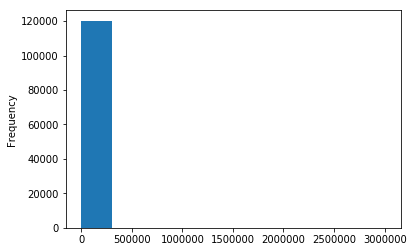

In [14]:
# 大部分人还是低收入，只有极少数高收入人群
train.MonthlyIncome.plot(kind='hist')

In [15]:
# 由于数据分布呈左偏，均值被少部分的高收入人群给拉高，大于中位数，因此这里以中位数填充缺失值
print('均值：', train.MonthlyIncome.mean())
print('中位数：',train.MonthlyIncome.median())

均值： 6670.221237392844
中位数： 5400.0


In [16]:
# 训练集
train.MonthlyIncome.fillna(train.MonthlyIncome.median(), inplace=True)

In [17]:
# 测试集
test.MonthlyIncome.fillna(train.MonthlyIncome.median(), inplace=True)

In [18]:
train.MonthlyIncome.isna().sum()

0

###### 对于NumberOfDependents，家庭受养人数

In [19]:
train.NumberOfDependents.value_counts()

0.0     86902
1.0     26316
2.0     19522
3.0      9483
4.0      2862
5.0       746
6.0       158
7.0        51
8.0        24
9.0         5
10.0        5
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

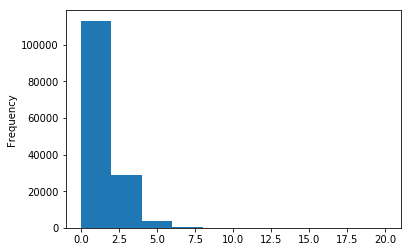

In [20]:
train.NumberOfDependents.plot(kind='hist')

In [21]:
# 大部分还是自己生活呢
print('均值：', train.NumberOfDependents.mean())
print('中位数：',train.NumberOfDependents.median())

均值： 0.7572222678605657
中位数： 0.0


In [22]:
# 训练集
train.NumberOfDependents.fillna(train.MonthlyIncome.median(), inplace=True)

In [23]:
# 测试集
test.NumberOfDependents.fillna(train.MonthlyIncome.median(), inplace=True)

In [24]:
train.MonthlyIncome.isna().sum()

0

#### 变量分桶
* age [-math.inf, 25, 40, 50, 60, 70, math.inf]
* NumberOfDependents 家属人数 [-math.inf,2,4,6,8,10,math.inf]
* NumberOfTime30-59DaysPastDueNotWorse，NumberOfTime60-89DaysPastDueNotWorse，NumberOfTimes90DaysLate三种逾期</b>
 [-math.inf,1,2,3,4,5,6,7,8,9,math.inf]
* 其余字段 RevolvingUtilizationOfUnsecuredLines, DebtRatio, MonthlyIncome, NumberOfOpenCreditLinesAndLoans, NumberRealEstateLoansOrLines 分五段 qcut(data, q=5)

In [25]:
import math

In [26]:
split_point = train.shape[0]
whole_data = train.append(test)

In [27]:
whole_data['age'] = pd.cut(whole_data.age, [-math.inf, 25, 40, 50, 60, 70, math.inf])
whole_data['NumberOfDependents'] = pd.cut(whole_data.NumberOfDependents, [-math.inf,2,4,6,8,10,math.inf])

whole_data['NumberOfTime30-59DaysPastDueNotWorse'] = pd.cut(whole_data['NumberOfTime30-59DaysPastDueNotWorse'], [-math.inf,1,2,3,4,5,6,7,8,9,math.inf])
whole_data['NumberOfTime60-89DaysPastDueNotWorse'] = pd.cut(whole_data['NumberOfTime60-89DaysPastDueNotWorse'], [-math.inf,1,2,3,4,5,6,7,8,9,math.inf])
whole_data['NumberOfTimes90DaysLate'] = pd.cut(whole_data['NumberOfTimes90DaysLate'], [-math.inf,1,2,3,4,5,6,7,8,9,math.inf])

whole_data.RevolvingUtilizationOfUnsecuredLines = pd.qcut(whole_data.RevolvingUtilizationOfUnsecuredLines , q=5, duplicates='drop')
whole_data.DebtRatio = pd.qcut(whole_data.DebtRatio , q=5, duplicates='drop')
whole_data.MonthlyIncome = pd.qcut(whole_data.MonthlyIncome , q=5, duplicates='drop')
whole_data.NumberOfOpenCreditLinesAndLoans = pd.qcut(whole_data.NumberOfOpenCreditLinesAndLoans , q=5, duplicates='drop')
whole_data.NumberRealEstateLoansOrLines = pd.qcut(whole_data.NumberRealEstateLoansOrLines , q=5, duplicates='drop')

In [28]:
# 学这个startswith的用法
# # 统计分箱字段，以bin_开头
# bin_cols = [c for c in df_train.columns.values if c.startswith('bin_')]
# bin_cols

##### pd.qcut 得注意一个参数duplicates='drop'，
* 因为有时候用频次来划分边界是会造成两个桶存在同一个取值，比如1000个数中0占了900个，1占100个，如果按q=2,分两个桶，则会500个0为桶1，400个1和100个0为桶2，这就会造成混乱，数值1到底是哪个桶？因此我们将其进行合并。。。
* 但合并也有不合理得地方，那就按规则来分吧

##### 那train和test是不是要合并后再分桶呢？
##### 按规则分的可以不用，但按频率分应该要合并后再分桶

In [29]:
train = whole_data.iloc[:split_point,:]
test = whole_data.iloc[split_point:,:]

#### 计算每个特征的WOE，IV

In [30]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1.0,"(0.702, 50708.0]","(40.0, 50.0]","(1.0, 2.0]","(0.466, 3.908]","(8233.0, 7727000.0]","(12.0, 85.0]","(-inf, 1.0]","(2.0, 54.0]","(-inf, 1.0]","(-inf, 2.0]"
1,0.0,"(0.702, 50708.0]","(25.0, 40.0]","(-inf, 1.0]","(-0.001, 0.133]","(-0.001, 3400.0]","(-0.001, 4.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"
2,0.0,"(0.271, 0.702]","(25.0, 40.0]","(-inf, 1.0]","(-0.001, 0.133]","(-0.001, 3400.0]","(-0.001, 4.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"
3,0.0,"(0.083, 0.271]","(25.0, 40.0]","(-inf, 1.0]","(-0.001, 0.133]","(-0.001, 3400.0]","(4.0, 6.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"
4,0.0,"(0.702, 50708.0]","(40.0, 50.0]","(-inf, 1.0]","(-0.001, 0.133]","(8233.0, 7727000.0]","(6.0, 9.0]","(-inf, 1.0]","(-0.001, 1.0]","(-inf, 1.0]","(-inf, 2.0]"


In [31]:
# 放一个临时值，计算各特征各标签的数量
train['count'] = 1

In [32]:
train.columns.tolist()[1:-1]

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [33]:
%%time
IV_list = []
fea_bin_woe = pd.DataFrame()
# 遍历每一个feature(除了第一个label,和最后一个count)
for col in train.columns.tolist()[1:-1]:
    
    feat = train.groupby([col, 'SeriousDlqin2yrs'], as_index=False)['count'].count()
    # 每个桶的总数
    sum = feat.groupby(col, as_index=False)['count'].sum()

    # 坏样本数
    bad = feat[feat.SeriousDlqin2yrs==1][sum.columns]
    bad['count']= bad['count'].apply(lambda x: 0 if str(x)=='nan' else x)
    bad.rename(columns={'count':'bad'}, inplace=True)

    # 好样本数
    good = feat[feat.SeriousDlqin2yrs==0][sum.columns]
    good['count']= good['count'].apply(lambda x: 0 if str(x)=='nan' else x)
    good.rename(columns={'count':'good'}, inplace=True)

    WOE = sum.merge(good, on=col).merge(bad, on=col)
    
    
    # 该桶好/坏的占比
    WOE['good_rate'] = WOE['good']/WOE['count']
    WOE['bad_rate'] = WOE['bad']/WOE['count']

    # 好/坏占总的好/坏的比例
    WOE['margin_good_rate'] = WOE.good/WOE.good.sum()
    WOE['margin_bad_rate'] = WOE.bad/WOE.bad.sum()
    
    # 其中NumberOfTime60-89DaysPastDueNotWorse存在bad为0的情况，因此需要用log1p避免结果为inf
    WOE['WOE'] = np.log1p(WOE['margin_bad_rate']/WOE['margin_good_rate'])

    # features bin woe
    temp = pd.DataFrame(WOE[[col,'WOE']])
    temp['features'] = col
    temp.columns = ['bin','woe', 'features']
    fea_bin_woe = pd.concat([fea_bin_woe, temp], axis=0)

    
    # WOE 只考虑的乘除，嘿嘿，不够全面，来个加减吧
    WOE['IV'] = (WOE['margin_bad_rate']-WOE['margin_good_rate']) * WOE['WOE']
    WOE = WOE[[col, 'WOE', 'IV']]

    # 每一列的总和，最主要是IV值
    WOE.loc['sum'] = ['sum'] + WOE.sum(axis=0).values.tolist()

    # 判断IV值是否小于0.1, 如果小于0.1则跳过
    IV = WOE.IV['sum']
    print('\n{}的IV值为：{}'.format(col, IV))
    if IV<0.1:
        print('Dropt...')
        train.drop(columns=col, inplace=True)
        test.drop(columns=col, inplace=True)
        continue
    IV_list.append([col,IV])
    print('Saved...')
        
    # 桶和WOE的对应关系
    transform_list = WOE.set_index(col)['WOE'] #, inplace=True)
    # 将RevolvingUtilizationOfUnsecuredLines转换成WOE编码
    train.loc[:,col]= train.loc[:,col].apply(lambda x: transform_list.loc[x])
    
    # 测试集
    test.loc[:,col]= test.loc[:,col].apply(lambda x: transform_list.loc[x])


RevolvingUtilizationOfUnsecuredLines的IV值为：0.5270952658076192
Saved...

age的IV值为：0.10630739209281985
Saved...

NumberOfTime30-59DaysPastDueNotWorse的IV值为：0.3406105523141427
Saved...

DebtRatio的IV值为：0.03194889657494044
Dropt...

MonthlyIncome的IV值为：0.028130802154365364
Dropt...

NumberOfOpenCreditLinesAndLoans的IV值为：0.02500753746836124
Dropt...

NumberOfTimes90DaysLate的IV值为：0.37470365850920745
Saved...

NumberRealEstateLoansOrLines的IV值为：0.006035388120960453
Dropt...

NumberOfTime60-89DaysPastDueNotWorse的IV值为：0.20329806205744644
Saved...

NumberOfDependents的IV值为：0.009196548559156475
Dropt...
Wall time: 673 ms


##### # 编码规则

In [34]:
fea_bin_woe = fea_bin_woe[['features', 'bin', 'woe']].reset_index(drop=True)
fea_bin_woe

,features,bin,woe
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0192]",0.243780
1,RevolvingUtilizationOfUnsecuredLines,"(0.0192, 0.083]",0.211270
2,RevolvingUtilizationOfUnsecuredLines,"(0.083, 0.271]",0.350975
3,RevolvingUtilizationOfUnsecuredLines,"(0.271, 0.702]",0.722034
4,RevolvingUtilizationOfUnsecuredLines,"(0.702, 50708.0]",1.497742
...,...,...,...
60,NumberOfDependents,"(2.0, 4.0]",0.880529
61,NumberOfDependents,"(4.0, 6.0]",0.948487
62,NumberOfDependents,"(6.0, 8.0]",0.890838
63,NumberOfDependents,"(8.0, 10.0]",0.000000


In [35]:
train.drop(columns='count', inplace=True)

In [36]:
train.isna().sum()

SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
NumberOfTimes90DaysLate                 0
NumberOfTime60-89DaysPastDueNotWorse    0
dtype: int64

#### 切分验证集

In [37]:
y_train = train.SeriousDlqin2yrs.values
x_train = train.drop(columns = 'SeriousDlqin2yrs').values

In [38]:
feat_col = train.drop(columns = 'SeriousDlqin2yrs').columns.tolist()

In [39]:
x_test = test.drop(columns = 'SeriousDlqin2yrs').values

#### Thinking: WOE还要不要做归一化呢？ 
* A: 结果差不多

In [40]:
# from sklearn.preprocessing import StandardScaler
# ss = StandardScaler()
# x_train_ss = ss.fit_transform(x_train)
# x_test_ss = ss.transform(x_test)

# from sklearn.model_selection import train_test_split
#x_train_ss, x_val_ss, y_train, y_val = train_test_split(x_train_ss, y_train, test_size=0.2, random_state=33)

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=33)

In [42]:
# 利用LR模型预测 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
lr = LogisticRegression(random_state=33)

In [43]:
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=33, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
y_pred = lr.predict(x_val)
print('ACC:', accuracy_score(y_pred, y_val))
print('ROC:', roc_auc_score(y_pred, y_val))

ACC: 0.9364333333333333
ROC: 0.7787691092695656


* 本项目主要利用WOE和IV来衡量特征变量的预测能力，或者说特征变量的特征区分度。并对原特征进行WOE编码，代替原特征输入模型，再者，剔除IV<0.1的特征，避免数据冗余。通过实验可以得出只利用筛选后的特征比无脑地将全量特征喂给模型更有效。

##### Thinking :
* WOE依赖于对原始特征的分箱操作，这个分箱并没有明确的理论指导，更多的是对业务的理解，譬如，年龄多大是青年、中年、老年，不同时代，人的寿命长短不一，划分的界限也不一样，因此，分箱是一个不太可控的因素。由于分箱的不准确，或者偏差较大，边界问题等，可能会导致IV值<0.1，最终导致该变量被丢弃。因此应该多尝试，多理解业务场景，这样更有利于我们对边界的定义。

### 利用LR的coef_查看哪个变量的重要性比较高，寻求可解释性

In [45]:
feat_imp = pd.DataFrame([feat_col, lr.coef_[0]]).T
IV_df = pd.DataFrame(IV_list)

In [46]:
feat_imp

,0,1
0,RevolvingUtilizationOfUnsecuredLines,1.43829
1,age,1.08714
2,NumberOfTime30-59DaysPastDueNotWorse,0.872805
3,NumberOfTimes90DaysLate,0.726142
4,NumberOfTime60-89DaysPastDueNotWorse,0.450155


In [47]:
IV_df

,0,1
0,RevolvingUtilizationOfUnsecuredLines,0.527095
1,age,0.106307
2,NumberOfTime30-59DaysPastDueNotWorse,0.340611
3,NumberOfTimes90DaysLate,0.374704
4,NumberOfTime60-89DaysPastDueNotWorse,0.203298


In [48]:
# 在训练好的LR中提取每个特征的系数与之前计算的IV值拼接
feat_imp_iv = feat_imp.merge(IV_df, on=0)
feat_imp_iv.columns = ['feature', 'importance', 'iv']
feat_imp_iv

,feature,importance,iv
0,RevolvingUtilizationOfUnsecuredLines,1.43829,0.527095
1,age,1.08714,0.106307
2,NumberOfTime30-59DaysPastDueNotWorse,0.872805,0.340611
3,NumberOfTimes90DaysLate,0.726142,0.374704
4,NumberOfTime60-89DaysPastDueNotWorse,0.450155,0.203298


##### 可以看到RevolvingUtilizationOfUnsecuredLines的权重最大，而对应的IV值也达到了0.527；但有一个现象，IV值为0.106，差点就被丢弃的age特征，在LR中的权重系数却排到了第二 1.087，这是为什么呢？

### 生成评分卡模型

In [49]:
pd.options.display.max_rows=65
#fea_bin_woe

In [50]:
# PDO = 50, B = 72.13
# odds=1， P0 = 650

lst = ['Variable', 'Bin', 'Score']
def generate_fea_bin_woe_score(fea_bin_woe, B, model_coef, iv_features):
    '''
    Score = A - LR的系数 * WOE * B
    Variable, Bin, WOE 来自规则表
    A, B 可计算(基于两个假设)
    LR系数：lr.coef_[0]
    '''
    fea_bin_woe_score = pd.DataFrame()
    coef = model_coef[0]
    for i in range(len(iv_features)):
        feat = iv_features[i][0]
        df = fea_bin_woe[fea_bin_woe.features == feat]
        df['Score'] = - coef[i]*df['woe']*B
        df = df[['features', 'bin', 'woe', 'Score']]
        fea_bin_woe_score = fea_bin_woe_score.append(df)
    return fea_bin_woe_score

In [51]:
fea_bin_woe_score = generate_fea_bin_woe_score(fea_bin_woe, B=72.13, model_coef=lr.coef_, iv_features=IV_list)

In [52]:
Scorecard = fea_bin_woe_score[['features', 'bin', 'Score']]
Scorecard

,features,bin,Score
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0192]",-25.290692
1,RevolvingUtilizationOfUnsecuredLines,"(0.0192, 0.083]",-21.918049
2,RevolvingUtilizationOfUnsecuredLines,"(0.083, 0.271]",-36.411579
3,RevolvingUtilizationOfUnsecuredLines,"(0.271, 0.702]",-74.906817
4,RevolvingUtilizationOfUnsecuredLines,"(0.702, 50708.0]",-155.381966
5,age,"(-inf, 25.0]",-79.445229
6,age,"(25.0, 40.0]",-74.904687
7,age,"(40.0, 50.0]",-63.816112
8,age,"(50.0, 60.0]",-51.099687
9,age,"(60.0, 70.0]",-31.903143


In [53]:
# 因为我们的train的每个字段已经映射到woe，因此我们可以通过fea_bin_woe_score中的fea_woe_score，将字段映射到score，再求每个用户的score
fea_bin_woe_score.head(3)

,features,bin,woe,Score
0,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0192]",0.243780,-25.290692
1,RevolvingUtilizationOfUnsecuredLines,"(0.0192, 0.083]",0.211270,-21.918049
2,RevolvingUtilizationOfUnsecuredLines,"(0.083, 0.271]",0.350975,-36.411579


In [54]:
train_col = train.columns.tolist()
for i in range(1, len(train_col)):
    # 通过col找到fea_bin_woe_score中的feature，再通过woe，找到score
    woe_score = fea_bin_woe_score[fea_bin_woe_score.features == train_col[i]][['woe', 'Score']]
    train.loc[:,train_col[i]] = train.loc[:,train_col[i]].apply(lambda x: woe_score[woe_score.woe==x]['Score'].values[0])

In [55]:
A = 1000
train['Score'] = A + train[train_col[1:]].sum(axis=1)

In [56]:
train.Score.describe()

count    150000.000000
mean        787.391359
std          73.997689
min         313.053832
25%         761.308854
50%         810.924979
75%         838.102621
max         867.292774
Name: Score, dtype: float64

In [57]:
Score = train[['SeriousDlqin2yrs', 'Score']]
Score['违约情况'] = Score.SeriousDlqin2yrs.apply(lambda x: '违约' if x == 1 else '未违约')
Score = Score[['Score', '违约情况']]

In [58]:
Score.sort_values(by='Score')

,Score,违约情况
41214,313.053832,违约
111668,333.141580,违约
98031,337.898619,违约
28118,337.898619,未违约
18526,337.898619,未违约
...,...,...
62027,867.292774,未违约
123784,867.292774,未违约
129365,867.292774,未违约
66779,867.292774,未违约


##### 可以看到最终的模型准确率时有点问题的，还需要进一步优化改进
- 考虑分桶的合理性，看又没特征被误删
- 由于正负样本的比例悬殊，因此，可以考虑过采样或欠采样等方法优化模型
- 考虑组合特征，例如特征两两组合，特征自身的线性变换

#### 小结：
- 评分卡模型主要利用对特征分桶，求WOE值、IV值，对IV值小于0.1的不重要特征进行丢弃，对其余特征进行WOE编码，利用woe编码后的值代替原始特征输入LR模型。根据两个假设(假设1，基准分；假设二，在odds翻倍时，分数减少PDO)和训练好的LR模型的系数，得到最终的评分。